In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


In [14]:
file_path = 'data/prices_round_3_day_1.csv'
data = pd.read_csv(file_path, encoding='cp1252', delimiter=';')

C:\Users\samue\AppData\Local\Temp\ipykernel_14420\4112973303.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_chocolate["mid_price"] *= 6


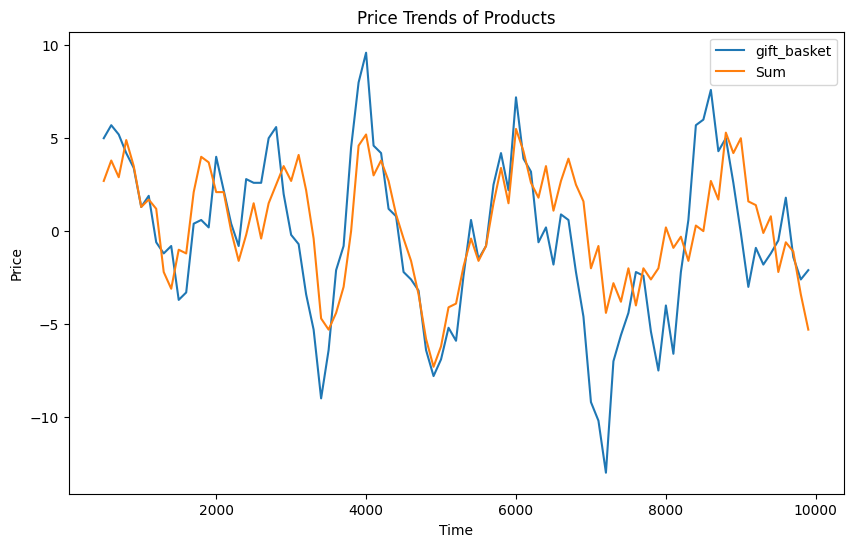

In [15]:

data_strawberries = data[data["product"] == "STRAWBERRIES"]
data_chocolate = data[data["product"] == "CHOCOLATE"]
data_roses = data[data["product"] == "ROSES"]
data_gift_basket = data[data["product"] == "GIFT_BASKET"]


price_strawberries = data_strawberries["mid_price"].astype(float) * 3
price_chocolate = data_chocolate["mid_price"].astype(float) * 6
price_roses = data_roses["mid_price"].astype(float)
price_gift_basket = data_gift_basket["mid_price"].astype(float)

data_chocolate["mid_price"] *= 6
data_strawberries['mid_price'] * 3

union = pd.concat([data_strawberries, data_chocolate, data_roses])

gifts = data_gift_basket.groupby("timestamp").agg({'mid_price' : 'sum'})
summed = union.groupby("timestamp").agg({'mid_price' : 'sum'})

# summed += 5000


combined_sum = price_strawberries + price_chocolate + price_roses

# Plot the prices
plt.figure(figsize=(10, 6))
plt.plot(gifts.rolling(5).mean().diff()[0:100], label="gift_basket")
plt.plot(summed.rolling(5).mean().diff()[0:100], label="Sum")
# plt.plot(price_roses, label="Roses")
# plt.plot(price_gift_basket, label="Gift Basket")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Trends of Products")
plt.legend()
plt.show()

In [16]:
union[union['timestamp'] == 0]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3,1,0,STRAWBERRIES,4030,237,NaN,NaN,NaN,NaN,4031,237,NaN,NaN,NaN,NaN,4030.5,0.0
1,1,0,CHOCOLATE,7987,104,NaN,NaN,NaN,NaN,7989,104,NaN,NaN,NaN,NaN,47928.0,0.0
2,1,0,ROSES,14545,27,14544.0,34.0,NaN,NaN,14546,61,NaN,NaN,NaN,NaN,14545.5,0.0


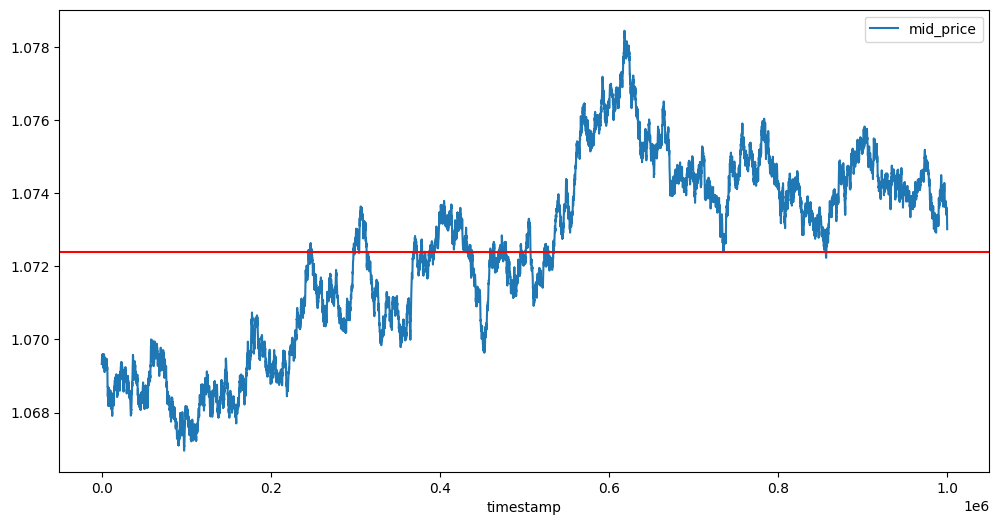

In [17]:
ratio = gifts/summed
ratio.plot(figsize=(12,6))
# plt.plot(ratio, color='blue')
plt.axhline(1.0724, color='red')
plt.show()

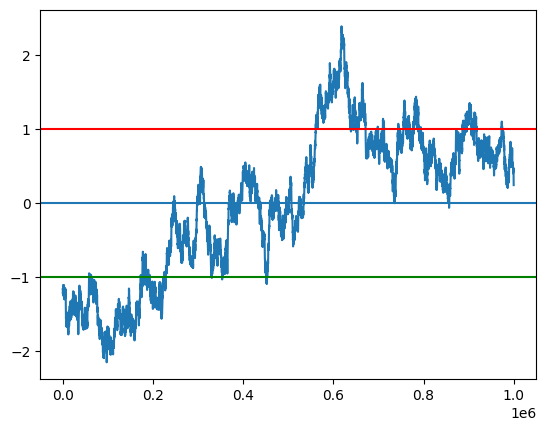

In [18]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


scored = zscore(ratio)

# scored.plot(figsize=(12,6))
plt.plot(scored)
plt.axhline(zscore(ratio).mean().iloc[0])
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()
#

In [19]:
print(len(ratio) * .70 ) 
a = 7000
train = ratio[0:a]
test = ratio[a:]

7000.0


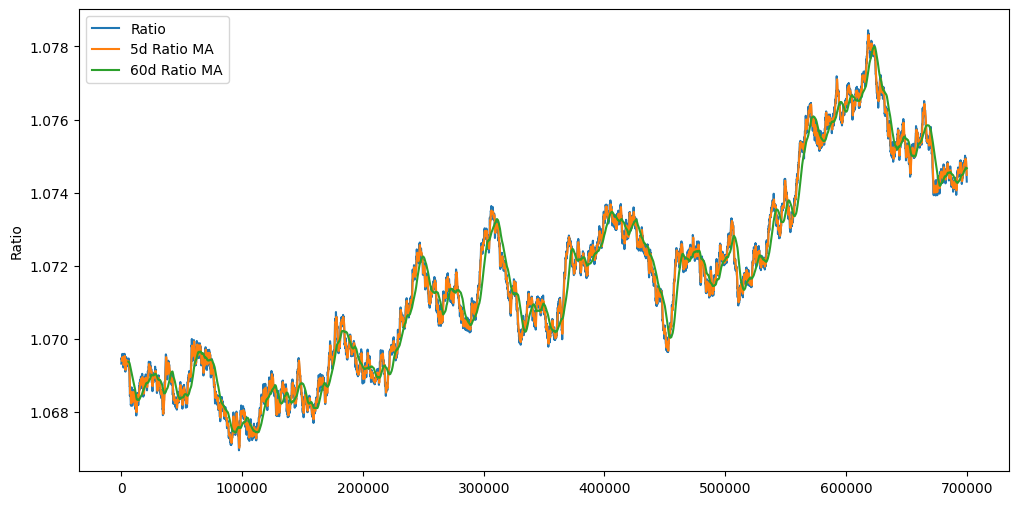

In [20]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

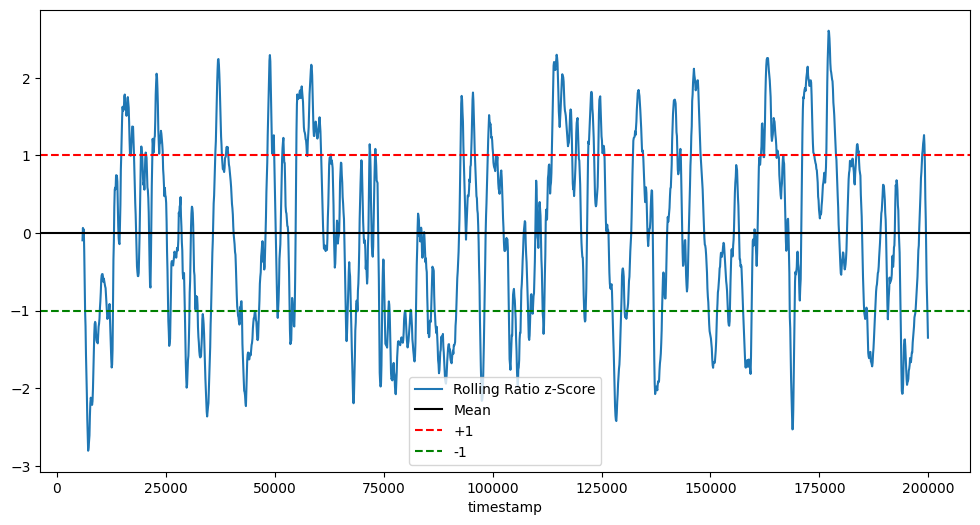

In [21]:
# plt.figure()
zscore_60_5[:2000].plot(figsize=(12,6))
# plt.xlim('2013-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

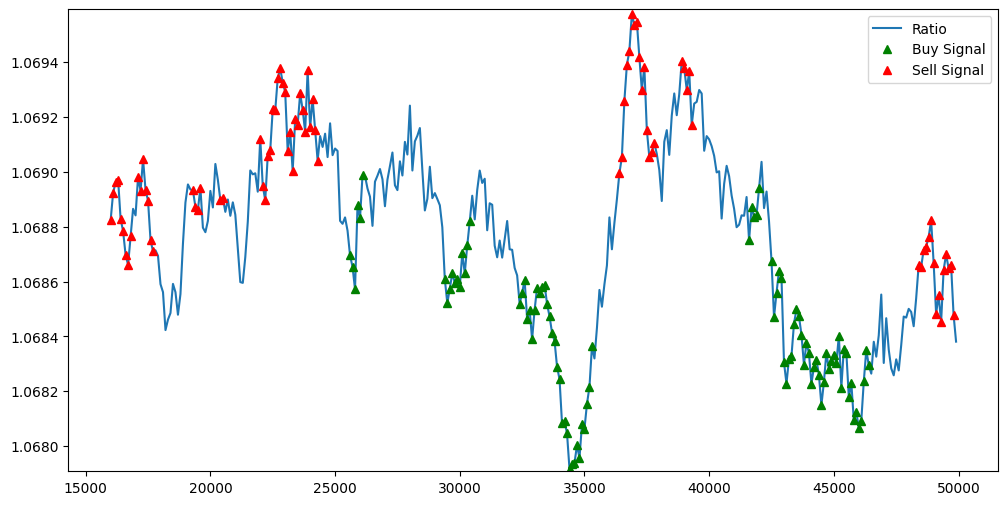

In [22]:
a = 500 
ratios = ratio[:a]

plt.figure(figsize=(12,6))
plt.plot(train[160:a])
# .plot(figsize=(12,6))
buy = train[:a].copy()
sell = train[:a].copy()

buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
plt.plot(buy[160:], color='g', linestyle='None', marker='^')
plt.plot(sell[160:], color='r', linestyle='None', marker='^')


x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min().iloc[0], ratios.max().iloc[0]))
# plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

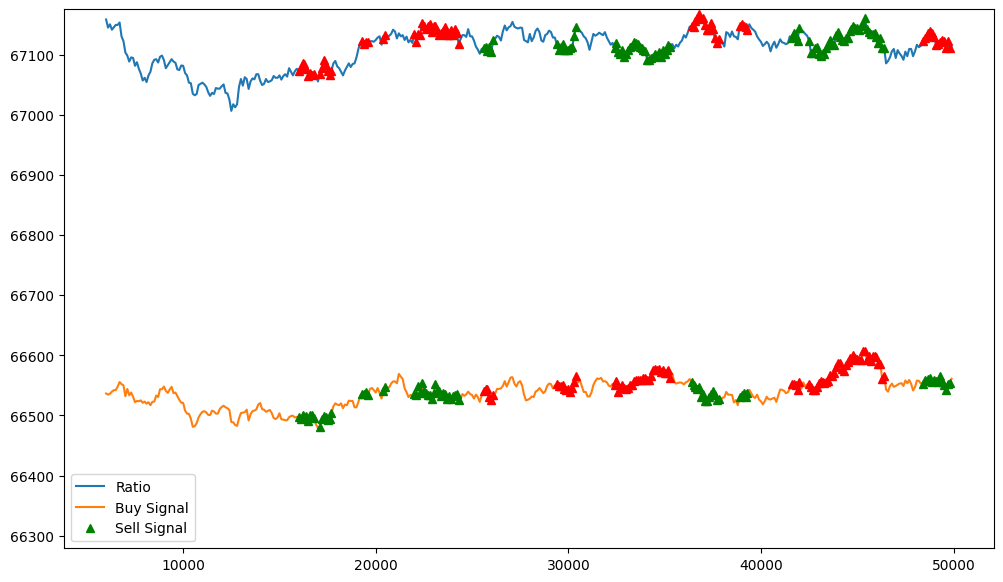

In [23]:
plt.figure(figsize=(12,7))
a = 500

S1 = gifts[:a] - 4000
S2 = summed[:a]

plt.plot(S1[60:])
plt.plot(S2[60:])

buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]


plt.plot(buyR[160:], color='g', linestyle='None', marker='^')
plt.plot(sellR[160:], color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, S2.min().iloc[0] - 200, S1.max().iloc[0]))
# plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()



# S1[60:].plot(color='b')
# S2[60:].plot(color='c')
# buyR = 0*S1.copy()
# sellR = 0*S1.copy()

# # When you buy the ratio, you buy stock S1 and sell S2
# buyR[buy!=0] = S1[buy!=0]
# sellR[buy!=0] = S2[buy!=0]

# # When you sell the ratio, you sell stock S1 and buy S2
# buyR[sell!=0] = S2[sell!=0]
# sellR[sell!=0] = S1[sell!=0]

# buyR[60:].plot(color='g', linestyle='None', marker='^')
# sellR[60:].plot(color='r', linestyle='None', marker='^')
# x1, x2, y1, y2 = plt.axis()
# plt.axis((x1, x2, min(S1.min().iloc[0], S2.min().iloc[0]), max(S1.max().iloc[0], S2.max().iloc[0])))
# plt.ylim(25, 105)
# plt.xlim('2013-03-22', '2016-07-04')

# plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
# plt.show()

In [24]:
S1, S2, window1, window2 = (gifts, summed, 60, 5)

ratios = S1/S2
ma1 = ratios.rolling(window=window1,
                            center=False).mean()
ma2 = ratios.rolling(window=window2,
                            center=False).mean()
std = ratios.rolling(window=window2,
                    center=False).std()
zscore = (ma1 - ma2)/std

zscore.iloc[60].item()


# Simulate trading
# Start with no money and no positions
money = 0
countS1 = 0
countS2 = 0
for i in range(len(ratios)):
# Sell short if the z-score is > 1
    if zscore.iloc[i].item() < -1:
        money += S1.iloc[i].item() - S2.iloc[i].item() * ratios.iloc[i].item()
        countS1 -= 1
        countS2 += ratios.iloc[i].item()
        # print('Selling Ratio %s %s %s %s'%(money, ratios.iloc[i].item(), countS1,countS2))


S1.iloc[132]
# print(len(ratios), len(S1), len(S2))

mid_price    71062.5
Name: 13200, dtype: float64

In [25]:
def trade(S1, S2, window1, window2):   
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i].item() < -1:
            money += S1.iloc[i].item() - S2.iloc[i].item() * ratios.iloc[i].item()
            countS1 -= 1
            countS2 += ratios.iloc[i].item()
            # print('Selling Ratio %s %s %s %s'%(money, ratios.iloc[i].item(), countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore.iloc[i].item() > 1:
            money -= S1.iloc[i].item() - S2.iloc[i].item() * ratios.iloc[i].item()
            countS1 += 1
            countS2 -= ratios.iloc[i].item()
            # print('Buying Ratio %s %s %s %s'%(money,ratios.iloc[i].item(), countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i].item()) < 0.75:
            money += S1.iloc[i].item() * countS1 + S2.iloc[i].item() * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios.iloc[i].item(), countS1,countS2))
            
            
    return money

trade(gifts[:1000], summed[:1000], 200, 5)

12917.265253531892

In [26]:
length_scores = [trade(gifts[:1000], summed[:1000], l, 5) for l in range(255)]

In [27]:
length_scores2 = [trade(gifts[1000:2000], summed[1000:2000], l, 5) for l in range(255)]

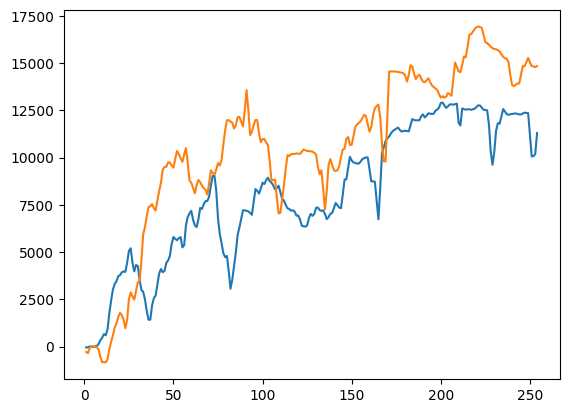

In [28]:
best_length = np.argmax(length_scores2)
plt.plot(pd.DataFrame(length_scores).rolling(2).mean())
plt.plot(pd.DataFrame(length_scores2).rolling(2).mean())

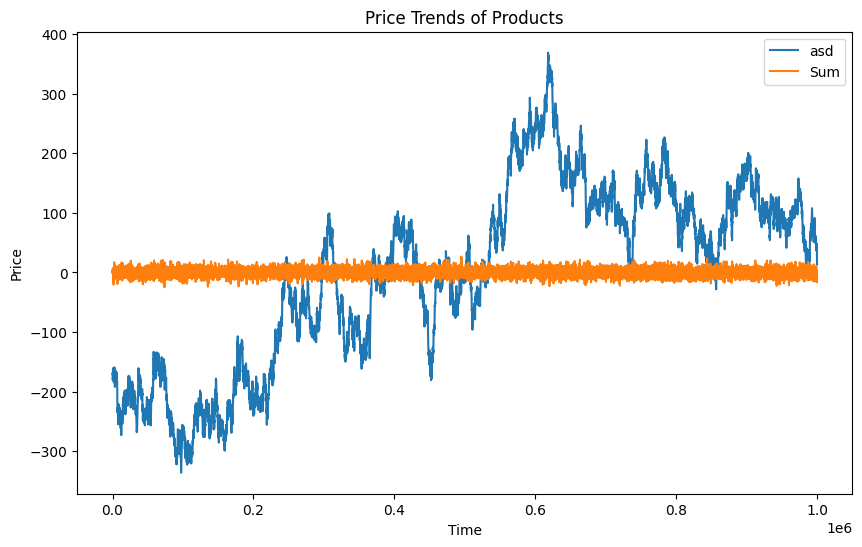

In [29]:
gifts.mean() - summed.mean()

# pd.concat([gifts, summed]).groupby("timestamp").agg({'': 'dif'})


a  = gifts - summed - (gifts.mean() - summed.mean())
plt.figure(figsize=(10, 6))
plt.plot(a, label="asd")
plt.plot(a.rolling(1).mean().diff(), label="Sum")
# plt.plot(price_roses, label="Roses")
# plt.plot(price_gift_basket, label="Gift Basket")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Trends of Products")
plt.legend()
plt.show()

In [30]:

b = a.rolling(5).mean().diff()
(a, b)

b.corrwith(a)

mid_price    0.042818
dtype: float64

In [31]:
for i in range(30):
    print(i, )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [32]:
a = gifts.rolling(i).mean().diff().corrwith(summed.rolling(i).mean().diff())

In [33]:
type(a)

pandas.core.series.Series

In [44]:
new_row = pd.DataFrame({'timestamp': [100], 'mid_price': [323]}).set_index('timestamp')
new_row

,mid_price
timestamp,
100,323


In [65]:
import jsonpickle
di = {"a":new_row}
# a = jsonpickle.encode(di)
# a = jsonpickle.decode(di)

pd.DataFrame(dict(new_row))



,mid_price
timestamp,
100,323


In [71]:
dict(new_row)

{'mid_price': timestamp
 100    323
 Name: mid_price, dtype: int64}

In [70]:
{'mid_price': timestamp\n691200    7753.5\nName: mid_price, dtype: float64}}

ValueError: DataFrame constructor not properly called!